<a href="https://colab.research.google.com/github/thyungkim/NetDissect-Improve-Accuracy/blob/main/netdissect_experimen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Network Dissection (for classifiers)
In this notebook, we will examine internal layer representations for a classifier trained to recognize scene categories.

Setup matplotlib, torch, and numpy for a high-resolution browser.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

!pip install Ninja
!wget https://developer.download.nvidia.com/compute/cuda/11.1.1/local_installers/cuda_11.1.1_455.32.00_linux.run
!chmod +x cuda_11.1.1_455.32.00_linux.run
!./cuda_11.1.1_455.32.00_linux.run --silent --toolkit --override
os.environ['PATH'] += ':/usr/local/cuda-11.1/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-11.1/lib64'
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 4.8 MB/s eta 0:00:00
--2023-03-09 20:48:14--  https://developer.download.nvidia.com/compute/cuda/11.1.1/local_installers/cuda_11.1.1_455.32.00_linux.run
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3532172082 (3.3G) [application/octet-stream]
Saving to: ‘cuda_11.1.1_455.32.00_linux.run’

a_11.1.1_455.32.00_  78%[==============>     ]   2.59G   184MB/s    eta 4s     

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
import IPython
mpl.rcParams['lines.linewidth'] = 0.25
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.linewidth'] = 0.25

Set up experiment directory and settings



In [ ]:
import torch, argparse, os, shutil, inspect, json, numpy, math
import show
from easydict import EasyDict
import dissect_experiment as experiment
# choices are alexnet, vgg16, or resnet152.
args = EasyDict(model='vgg16', dataset='cifar', seg='netpqc', layer='conv5_3', quantile=0.01)
resdir = 'results/%s-%s-%s-%s-%s' % (args.model, args.dataset, args.seg, args.layer, int(args.quantile * 1000))
def resfile(f):
    return os.path.join(resdir, f)

In [ ]:
!rm -rf 'datasets'

load classifier model and dataset



In [ ]:
model = experiment.load_model(args)
layername = experiment.instrumented_layername(args)
model.retain_layer(layername)
dataset = experiment.load_dataset(args)
print(dataset)
upfn = experiment.make_upfn(args, dataset, model, layername)
sample_size = len(dataset)
percent_level = 1.0 - args.quantile

print('Inspecting layer %s of model %s on %s' % (layername, args.model, args.dataset))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets


RuntimeError: ignored

Load segmenter, segment labels, classifier labels



In [ ]:
# Classifier labels
from urllib.request import urlopen
import renormalize

# synset_url = 'http://gandissect.csail.mit.edu/models/categories_places365.txt'
# classlabels = [r.split(' ')[0][3:] for r in urlopen(synset_url).read().decode('utf-8').split('\n')]
classlabels = dataset.classes
segmodel, seglabels, segcatlabels = experiment.setting.load_segmenter(args.seg)
renorm = renormalize.renormalizer(dataset, target='zc')

Loading weights for net_encoder
Loading weights for net_decoder


Test classifier on some images


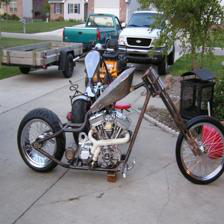
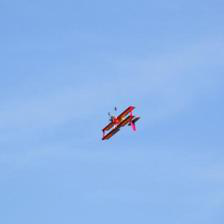
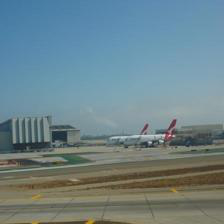
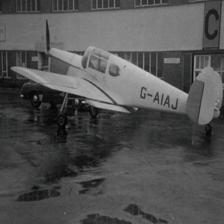
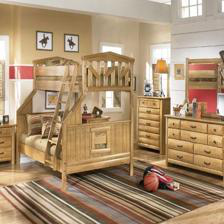
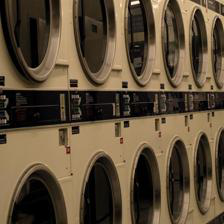
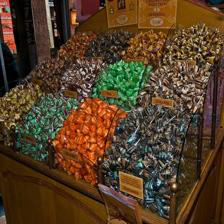
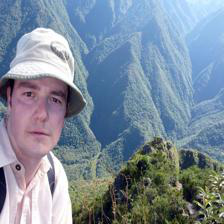

In [ ]:
import renormalize

indices = [200, 755, 709, 423, 60, 100, 110, 120]
batch = torch.cat([dataset[i][0][None,...] for i in indices])
truth = [classlabels[dataset[i][1]] for i in indices]
preds = model(batch.cuda()).max(1)[1]
imgs = [renormalize.as_image(t, source=dataset) for t in batch]
prednames = [classlabels[p.item()] for p in preds]
show([[img, 'pred: ' + pred, 'true: ' + gt] for img, pred, gt in zip(imgs, prednames, truth)])

segment single image, and visualize the labels



/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


,
,grey
,black
,green
,blue
,white
,pink
,brown
,
,blue
,red

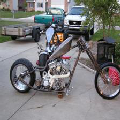
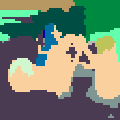
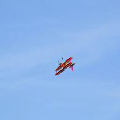
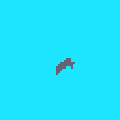
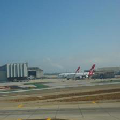
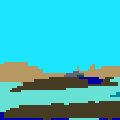
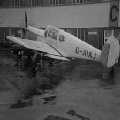
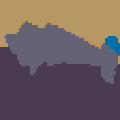
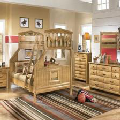
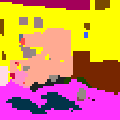
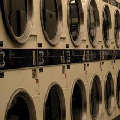
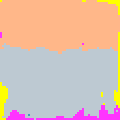
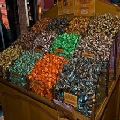
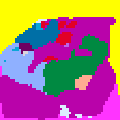
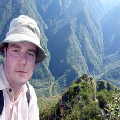
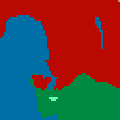

In [ ]:
import imgviz

iv = imgviz.ImageVisualizer(120, source=dataset)
seg = segmodel.segment_batch(renorm(batch).cuda(), downsample=4)

show([(iv.image(batch[i]), iv.segmentation(seg[i,0]),
            iv.segment_key(seg[i,-1], segmodel))
            for i in range(len(seg))])

visualize activations for single layer of single image




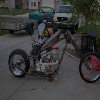
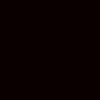
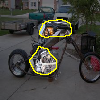
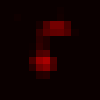
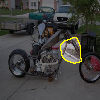
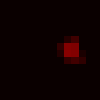
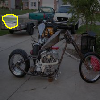
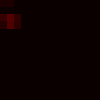
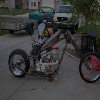
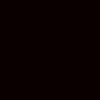
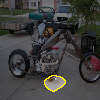
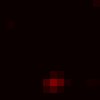
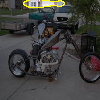
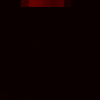
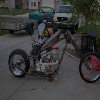
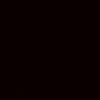
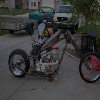
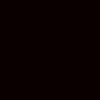
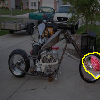
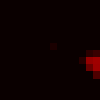
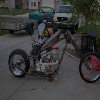
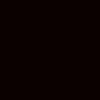
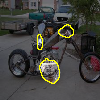
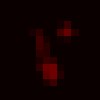

In [ ]:
import imgviz

acts = model.retained_layer(layername).cpu()
ivsmall = imgviz.ImageVisualizer((100, 100), source=dataset)
display(show.blocks(
    [[[ivsmall.masked_image(batch[0], acts, (0, u), percent_level=0.99)],
      [ivsmall.heatmap(acts, (0, u), mode='nearest')]] for u in range(min(acts.shape[1], 12))]
))

num_units = acts.shape[1]

##Collect quantile statistics
First, unconditional quantiles over the activations. We will upsample them to 56x56 to match with segmentations later.

In [ ]:
import pbar
import tally
pbar.descnext('rq')
def compute_samples(batch, *args):
    image_batch = batch.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    hacts = upfn(acts)
    return hacts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1])
rq = tally.tally_quantile(compute_samples, dataset,
                          sample_size=sample_size,
                          r=8192,
                          num_workers=100,
                          pin_memory=True,
                          cachefile=resfile('rq.npz'))

Loading cached results/vgg16-places-netpqc-conv5_3-10/rq.npz


##Visualize Units
Collect topk stats first.

In [ ]:
pbar.descnext('topk')
def compute_image_max(batch, *args):
    image_batch = batch.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    acts = acts.view(acts.shape[0], acts.shape[1], -1)
    acts = acts.max(2)[0]
    return acts
topk = tally.tally_topk(compute_image_max, dataset, sample_size=sample_size,
        batch_size=50, num_workers=30, pin_memory=True,
        cachefile=resfile('topk.npz'))

Loading cached results/vgg16-places-netpqc-conv5_3-10/topk.npz


tensor(30063) ('datasets/places/val/elevator-door/Places365_val_00003570.jpg', 129)



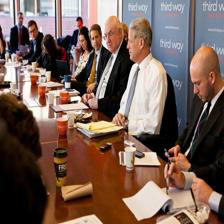


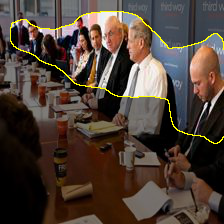

In [ ]:
# single image visualization
print(topk.result()[1][10][6], dataset.images[topk.result()[1][10][6]])
image_number = topk.result()[1][10][4].item()
unit_number = 10
iv = imgviz.ImageVisualizer((224, 224), source=dataset, quantiles=rq,
        level=rq.quantiles(percent_level))
batch = torch.cat([dataset[i][0][None,...] for i in [image_number]])
truth = [classlabels[dataset[i][1]] for i in [image_number]]
preds = model(batch.cuda()).max(1)[1]
imgs = [renormalize.as_image(t, source=dataset) for t in batch]
prednames = [classlabels[p.item()] for p in preds]
acts = model.retained_layer(layername)
show([[img, 'pred: ' + pred, 'true: ' + gt] for img, pred, gt in zip(imgs, prednames, truth)])
show([[iv.masked_image(batch[0], acts, (0, unit_number))]])

Then we just need to run through and visualize the images.



In [ ]:
pbar.descnext('unit_images')

iv = imgviz.ImageVisualizer((100, 100), source=dataset, quantiles=rq,
        level=rq.quantiles(percent_level))
def compute_acts(image_batch, *ignored_class):
    image_batch = image_batch.cuda()
    _ = model(image_batch)
    acts_batch = model.retained_layer(layername)
    return acts_batch
unit_images = iv.masked_images_for_topk(
        compute_acts, dataset, topk, k=5, num_workers=30, pin_memory=True,
        cachefile=resfile('top5images.npz'))

Loading cached results/vgg16-places-netpqc-conv5_3-10/top5images.npz


unit 10


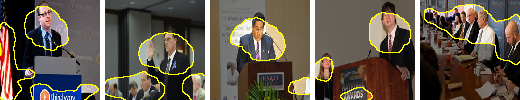

unit 20


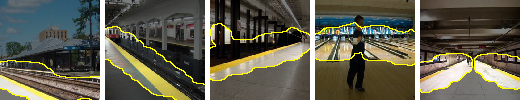

unit 30


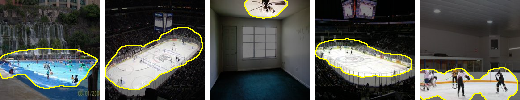

unit 40


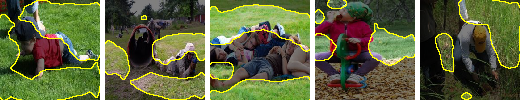

unit 19


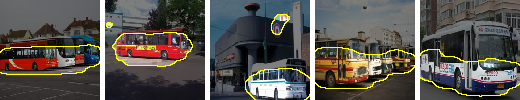

unit 190


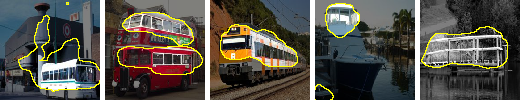

In [ ]:
for u in [10, 20, 30, 40, 19, 190]:
    print('unit %d' % u)
    display(unit_images[u])

##Label Units
Collect 99% quantile stats.

In [ ]:
level_at_99 = rq.quantiles(percent_level).cuda()[None,:,None,None]
# Use the segmodel for segmentations.  With broden, we could use ground truth instead.
def compute_conditional_indicator(batch, *args):
    image_batch = batch.cuda()
    seg = segmodel.segment_batch(renorm(image_batch), downsample=4)
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    hacts = upfn(acts)
    iacts = (hacts > level_at_99).float() # indicator
    return tally.conditional_samples(iacts, seg)
pbar.descnext('condi99')
condi99 = tally.tally_conditional_mean(compute_conditional_indicator,
        dataset, sample_size=sample_size,
        num_workers=3, pin_memory=True,
        cachefile=resfile('condi99.npz'))

Loading cached results/vgg16-places-netpqc-conv5_3-10/condi99.npz


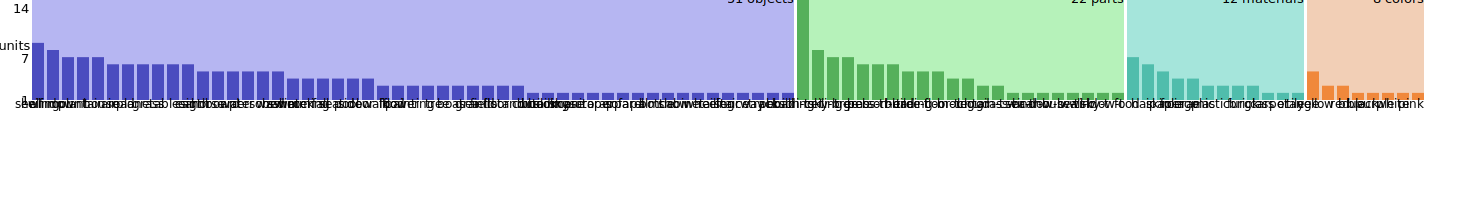

266

In [ ]:

iou_99 = tally.iou_from_conditional_indicator_mean(condi99)
unit_label_99 = [
        (concept.item(), seglabels[concept], segcatlabels[concept], bestiou.item())
        for (bestiou, concept) in zip(*iou_99.max(0))]
label_list = [labelcat for concept, label, labelcat, iou in unit_label_99 if iou > 0.04]
display(IPython.display.SVG(experiment.graph_conceptcatlist(label_list)))
len(label_list)

Show a few units with their labels



unit 10, label person-t, iou 0.052


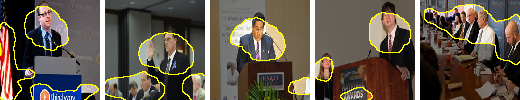

unit 20, label road, iou 0.046


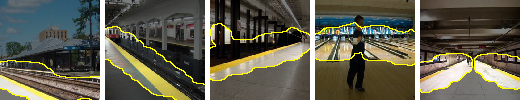

unit 30, label sidewalk, iou 0.026


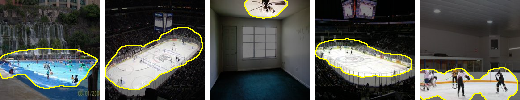

unit 40, label grass-b, iou 0.169


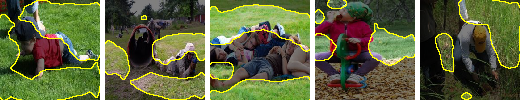

In [ ]:
for u in [10, 20, 30, 40]:
    print('unit %d, label %s, iou %.3f' % (u, unit_label_99[u][1], unit_label_99[u][3]))
    display(unit_images[u])